# Summary

## Lemmatized Statements for Machine Learning
Lemmatized Statements (removed whitespaces, puncuation, stopwords, special characters; converted to lowercase)

## Tagged Statements
POS (part of speech): Is this word an adjective, noun, something else?

NER (named entity recognition tagging): tags the kind of noun--person, place, organization, etc.--among other things

SD (syntatic dependency): the relation between tokens

## Features Engineered from Statements
No. of characters

No. of words

Avg. length of words

Readability score

## Statistics (only Statements, not lemmas, revealed statistically significant results)

### Significantly higher for Truth
Statement Count: Character & Word count

General (15 tags) POS tagging: adj., conjunction+ (i.e., "of", "about", "to", etc.), noun, number, determiner (i.e., "a", "an", "the")

Specific (52 tags) POS tagging: cardinal numbers, determiners, conjunctions(subordinating or preposition), adjective(comparative), noun(singular or mass)

NER: references to dates, percentages, numbers

SD: adjectival modifier, determiner, numeric modifier, object of preposition, prepositional modifier

### Significantly higher for Falsehoods
Statement Length: Average word length

Specific (52 tags) POS tagging: verb (modal auxiliary), superfluous punctuation

NER: references to people

SD: clausal complement, clausal subject



In [1]:
# import packages not on my computer through jupyter notebooks

# import sys
# !{sys.executable} -m pip install textatistic
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en_core_web_sm # doesn't include word vectors
# !{sys.executable} -m spacy download en_core_web_md # includes word vectors

In [156]:
# for Data Manipulation
import pandas as pd
import numpy as np
import os
import csv 

# for EDA
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline   
from collections import Counter

# for NLP
from textatistic import Textatistic
import spacy
from spacy import displacy

# for Statistics
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [3]:
# Use cleaner absolute path to find file
path = os.path.abspath('politifact_cleaned_data.csv')
df = pd.read_csv(path, index_col=0)

# to see statement in full
pd.set_option('display.max_colwidth', 200) 

# See sample of data
df.head(3)

,date,source,freq,statement,veracity
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False
21,2019-10-22,Brett McGurk,1,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",True
27,2019-10-21,Beto O'Rourke,3,"""To be clear, I’m not talking about confiscating anybody’s guns.""",False


# Dataframe column label explanations
date = date statement was made

source = source of statement

freq = frequency which source occurs in dataframe

statement = the statement which was evaluated for veracity at https://www.politifact.com

veracity = the truthfulness of a statement

In [4]:
df.veracity.value_counts()

False             576
True              571
Pants on Fire!    308
Name: veracity, dtype: int64

# Preprocessing Steps: Creating a condensed (lemmatized) text
Start: Original Text

1) Lowercasing: Examples -> examples

2) Reduction to root form: examples -> example

End: Lemmatized Text

# Other Text Preprocessing Techniques
removing whitespaces, punctuation, stopwords, special characters (numbers, etc.), html/xml tags

expanding contractions (may not be needed if stopwords removed since contracted words are typically stopwords)

replacing accented characters

correcting spelling errors

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
# lemmatization function
def lemmatize(text):
    # create nlp object
    nobj = nlp(text)
    
    # stopword list from spacy
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    # simple lemmas
    lemmas = [token.lemma_ for token in nobj]
    
    # lowercase; remove non-alphabetic characters & overly used words, i.e., stop words
    a_lemmas = [lemma.lower() for lemma in lemmas
                if lemma.isalpha() 
                and lemma not in stopwords]
    
    # strings
    strings = " ".join(a_lemmas)
    
    return strings

In [7]:
# sample: removes whitespaces, puncuation, stopwords, special characters; converts to lowercase
lemmatize(" ! i don't, won't,   can't not use    NLP 27x maaaah?")

'use nlp maaaah'

In [8]:
df["lemmas"] = df.statement.apply(lemmatize)

In [9]:
df[500:1500:500]

,date,source,freq,statement,veracity,lemmas
5223,2016-03-10,Jeff DeWit,1,"""Now we have ISIS coming over the (U.S.-Mexico) border.""",False,isis come border
11381,2012-03-13,Hank Johnson,1,"""In the last two years, super PACs raised more than $180 million -- with roughly half of it coming from fewer than 200 super-rich people and roughly 20 percent from corporations.""",True,year super pac raise million roughly half come super rich people roughly percent corporation


# Tagging Text
POS (parts of speech; POS Tagging): Is this word an adjective, noun, something else?

NER (named entity recognition tagging; tags the kind of noun--person, place, organization, etc.--among other things)

SD (syntatic dependency): the relation between tokens

# Part of Speech (POS) Tagging

## .pos_ (general pos tagging -- 15 tags)
#### .pos_ tags are based on the Google Universal POS Tags (spaCy extends the list)

In [159]:
# .pos_ example
nobj = nlp(df.statement[21])
pos = [(token.text, token.pos_) for token in nobj]
print(pos)

[('"', 'PUNCT'), ('President', 'PROPN'), ('Trump', 'PROPN'), ('has', 'AUX'), ('sent', 'VERB'), ('14,000', 'NUM'), ('American', 'ADJ'), ('troops', 'NOUN'), ('to', 'ADP'), ('the', 'DET'), ('(', 'PUNCT'), ('Middle', 'PROPN'), ('East', 'PROPN'), (')', 'PUNCT'), ('region', 'NOUN'), ('since', 'SCONJ'), ('May.', 'PROPN'), ('So', 'ADV'), ('he', 'PRON'), ('ca', 'VERB'), ("n't", 'PART'), ('tell', 'VERB'), ('his', 'PRON'), ('political', 'ADJ'), ('rallies', 'NOUN'), ('that', 'SCONJ'), ('he', 'PRON'), ("'s", 'AUX'), ('getting', 'VERB'), ('troops', 'NOUN'), ('out', 'SCONJ'), ('of', 'ADP'), ('endless', 'ADJ'), ('wars', 'NOUN'), ('when', 'ADV'), ('he', 'PRON'), ("'s", 'AUX'), ('sending', 'VERB'), ('14', 'NUM'), ('times', 'NOUN'), ('the', 'DET'), ('amount', 'NOUN'), ('back', 'ADV'), ('into', 'ADP'), ('the', 'DET'), ('region', 'NOUN'), ('.', 'PUNCT'), ('"', 'PUNCT')]


In [11]:
def dot_pos_tagger(text):
    # nlp object
    nobj = nlp(text)
    # POS tags
    tagged_text = [(token.text, token.pos_) for token in nobj]
    # tagged text
    return tagged_text

df["general_pos_tags"] = df.statement.apply(dot_pos_tagger)

In [12]:
df[["general_pos_tags"]][0:2]

,general_pos_tags
18,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),..."
21,"[("", PUNCT), (President, PROPN), (Trump, PROPN), (has, AUX), (sent, VERB), (14,000, NUM), (American, ADJ), (troops, NOUN), (to, ADP), (the, DET), ((, PUNCT), (Middle, PROPN), (East, PROPN), (), PU..."


the tagger works

## .tag_ (specific pos tagging -- 52 tags)
#### .tag_ uses OntoNotes 5 from the Penn Treebank tag set

In [13]:
# .tag_ example (more specific pos tagging)
nobj = nlp(df.statement[21])
pos = [(token.text, token.tag_) for token in nobj]
print(pos)

[('"', '``'), ('President', 'NNP'), ('Trump', 'NNP'), ('has', 'VBZ'), ('sent', 'VBN'), ('14,000', 'CD'), ('American', 'JJ'), ('troops', 'NNS'), ('to', 'IN'), ('the', 'DT'), ('(', '-LRB-'), ('Middle', 'NNP'), ('East', 'NNP'), (')', '-RRB-'), ('region', 'NN'), ('since', 'IN'), ('May.', 'NNP'), ('So', 'RB'), ('he', 'PRP'), ('ca', 'MD'), ("n't", 'RB'), ('tell', 'VB'), ('his', 'PRP$'), ('political', 'JJ'), ('rallies', 'NNS'), ('that', 'IN'), ('he', 'PRP'), ("'s", 'VBZ'), ('getting', 'VBG'), ('troops', 'NNS'), ('out', 'IN'), ('of', 'IN'), ('endless', 'JJ'), ('wars', 'NNS'), ('when', 'WRB'), ('he', 'PRP'), ("'s", 'VBZ'), ('sending', 'VBG'), ('14', 'CD'), ('times', 'NNS'), ('the', 'DT'), ('amount', 'NN'), ('back', 'RB'), ('into', 'IN'), ('the', 'DT'), ('region', 'NN'), ('.', '.'), ('"', "''")]


In [14]:
def dot_tag_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.tag_) for token in nobj]
    # tagged text
    return tagged_text

df["specific_pos_tags"] = df.statement.apply(dot_tag_tagger)

In [15]:
df[["specific_pos_tags"]][0:2]

,specific_tags
18,"[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,..."
21,"[("", ``), (President, NNP), (Trump, NNP), (has, VBZ), (sent, VBN), (14,000, CD), (American, JJ), (troops, NNS), (to, IN), (the, DT), ((, -LRB-), (Middle, NNP), (East, NNP), (), -RRB-), (region, NN..."


# NER (named-entity recognition) tagging

In [192]:
# NER example
nobj = nlp(df.statement[21])
displacy.render(nobj, style = "ent", jupyter = True)

In [16]:
# ner function
def ner_tagger(text):
    # nlp object
    nobj = nlp(text)
    # ner tags
    ne = [(ent.text, ent.label_) for ent in nobj.ents]
    return ne

In [17]:
df["ner_tags"] = df.statement.apply(ner_tagger)

In [18]:
df[["ner_tags"]][0:2]

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]"
21,2019-10-22,Brett McGurk,1,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",True,president trump send american troop middle east region may tell political rally troop endless war send time region,"[("", PUNCT), (President, PROPN), (Trump, PROPN), (has, AUX), (sent, VERB), (14,000, NUM), (American, ADJ), (troops, NOUN), (to, ADP), (the, DET), ((, PUNCT), (Middle, PROPN), (East, PROPN), (), PU...","[("", ``), (President, NNP), (Trump, NNP), (has, VBZ), (sent, VBN), (14,000, CD), (American, JJ), (troops, NNS), (to, IN), (the, DT), ((, -LRB-), (Middle, NNP), (East, NNP), (), -RRB-), (region, NN...","[(Trump, PERSON), (14,000, CARDINAL), (American, NORP), (Middle East, LOC), (14, CARDINAL)]"


# SD (Syntatic Dependency) tagging

In [164]:
# .tag_ example (more specific pos tagging)
nobj = nlp(df.statement[21])
sd = [(token.text, token.dep_) for token in nobj]
print(sd)

[('"', 'punct'), ('President', 'compound'), ('Trump', 'nsubj'), ('has', 'aux'), ('sent', 'ROOT'), ('14,000', 'nummod'), ('American', 'amod'), ('troops', 'dobj'), ('to', 'dative'), ('the', 'det'), ('(', 'punct'), ('Middle', 'nmod'), ('East', 'nmod'), (')', 'punct'), ('region', 'pobj'), ('since', 'prep'), ('May.', 'compound'), ('So', 'advmod'), ('he', 'nsubj'), ('ca', 'aux'), ("n't", 'neg'), ('tell', 'ROOT'), ('his', 'poss'), ('political', 'amod'), ('rallies', 'dobj'), ('that', 'mark'), ('he', 'nsubj'), ("'s", 'aux'), ('getting', 'ccomp'), ('troops', 'dobj'), ('out', 'prep'), ('of', 'prep'), ('endless', 'amod'), ('wars', 'pobj'), ('when', 'advmod'), ('he', 'nsubj'), ("'s", 'aux'), ('sending', 'advcl'), ('14', 'nummod'), ('times', 'quantmod'), ('the', 'det'), ('amount', 'dobj'), ('back', 'advmod'), ('into', 'prep'), ('the', 'det'), ('region', 'pobj'), ('.', 'punct'), ('"', 'punct')]


In [14]:
# sd function
def sd_tagger(text):
    # nlp object
    nobj = nlp(text)
    # tags
    tagged_text = [(token.text, token.dep_) for token in nobj]
    # tagged text
    return tagged_text

df["sd_tags"] = df.statement.apply(sd_tagger)

In [15]:
df[["sd_tags"]][0:2]

,specific_tags
18,"[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,..."
21,"[("", ``), (President, NNP), (Trump, NNP), (has, VBZ), (sent, VBN), (14,000, CD), (American, JJ), (troops, NNS), (to, IN), (the, DT), ((, -LRB-), (Middle, NNP), (East, NNP), (), -RRB-), (region, NN..."


# Feature Engineering from the original text and its lemma version
No. of characters

No. of words

Avg. length of words

In [19]:
# no. of characters
df["statement_char_count"] = df.statement.apply(len)

In [20]:
# no. of words function
def word_counter(text):
    
    # split text by blank spaces
    words = text.split()
    
    # count words
    return len(words)

In [21]:
# no. of words
df["statement_word_count"] = df.statement.apply(word_counter)

In [22]:
# avg. word length function
def avg_word_length(text):
    
    # split text into words
    words = text.split()
    
    # length of each word
    word_lengths = [len(w) for w in words] 
    
    # avg length
    avg_length = sum(word_lengths)/len(word_lengths)     
    return round((avg_length),1)

In [23]:
# avg. word length
df["statement_avg_word_len"] = df.statement.apply(avg_word_length)

In [24]:
df.head(3)

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]",93,16,4.9
21,2019-10-22,Brett McGurk,1,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",True,president trump send american troop middle east region may tell political rally troop endless war send time region,"[("", PUNCT), (President, PROPN), (Trump, PROPN), (has, AUX), (sent, VERB), (14,000, NUM), (American, ADJ), (troops, NOUN), (to, ADP), (the, DET), ((, PUNCT), (Middle, PROPN), (East, PROPN), (), PU...","[("", ``), (President, NNP), (Trump, NNP), (has, VBZ), (sent, VBN), (14,000, CD), (American, JJ), (troops, NNS), (to, IN), (the, DT), ((, -LRB-), (Middle, NNP), (East, NNP), (), -RRB-), (region, NN...","[(Trump, PERSON), (14,000, CARDINAL), (American, NORP), (Middle East, LOC), (14, CARDINAL)]",232,40,4.8
27,2019-10-21,Beto O'Rourke,3,"""To be clear, I’m not talking about confiscating anybody’s guns.""",False,clear talk confiscate anybody gun,"[("", PUNCT), (To, PART), (be, AUX), (clear, ADJ), (,, PUNCT), (I, PRON), (’m, VERB), (not, PART), (talking, VERB), (about, ADP), (confiscating, VERB), (anybody, PRON), (’s, NOUN), (guns, NOUN), (....","[("", ``), (To, TO), (be, VB), (clear, JJ), (,, ,), (I, PRP), (’m, VBP), (not, RB), (talking, VBG), (about, IN), (confiscating, VBG), (anybody, NN), (’s, NN), (guns, NNS), (., .), ("", '')]",[],65,10,5.6


# statistics

In [79]:
# func for comparing truth vs lie
def tvsf(column_label):
    
    # t & f variables
    truths = df[df['veracity'] == 'True'][column_label]
    falsehoods = df[df['veracity'] == 'False'][column_label]
    
    # means
    truths_mean = round(truths.mean(), 1)
    falsehoods_mean = round(falsehoods.mean(), 1)
    
    # t-test
    t,p = stats.ttest_ind(truths,
                          falsehoods, 
                          equal_var = False)
    if p <= 0.05:
        print("!!! SIGNIFICANT !!!")
        print(column_label, "p-value:", "{:.3f}".format(p))
    else:
        print("-Not Sgnfcnt-")
        print(column_label, "p-value:", "{:.3f}".format(p))
    print("T Avg.", column_label, ":", truths_mean)
    print("F Avg.", column_label, ":", falsehoods_mean)

In [81]:
tvsf("statement_char_count")

!!! SIGNIFICANT !!!
statement_char_count p-value: 0.042
T Avg. statement_char_count : 108.8
F Avg. statement_char_count : 103.4


In [27]:
tvsf("statement_word_count")

!!! SIGNIFICANT !!!
statement_word_count p-value: 0.021
T Avg. statement_word_count : 18.4
F Avg. statement_word_count : 17.3


In [28]:
tvsf("statement_avg_word_len")

!!! SIGNIFICANT !!!
statement_avg_word_len p-value: 0.003
T Avg. statement_avg_word_len : 5.0
F Avg. statement_avg_word_len : 5.2


#### Character & Word count are statistically higher for Truth
#### Average word length is statistically higher for Falsehoods
#### Hypothesis: Truthful people say more with a less sophisticated vocabulary

# lemma statistics

In [29]:
# with try and except
# b/c some lemmas do not contain words
def try_avg_word_len(text):
    try:
        return round(avg_word_length(text),1)
    except ZeroDivisionError:
        return -1

df["lemma_char_count"] = df.lemmas.apply(len)
df["lemma_word_count"] = df.lemmas.apply(word_counter)
df["lemma_avg_word_len"] = df.lemmas.apply(try_avg_word_len)

In [30]:
df.head(2)

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]",93,16,4.9,59,9,5.7
21,2019-10-22,Brett McGurk,1,"""President Trump has sent 14,000 American troops to the (Middle East) region since May. So he can't tell his political rallies that he's getting troops out of endless wars when he's sending 14 tim...",True,president trump send american troop middle east region may tell political rally troop endless war send time region,"[("", PUNCT), (President, PROPN), (Trump, PROPN), (has, AUX), (sent, VERB), (14,000, NUM), (American, ADJ), (troops, NOUN), (to, ADP), (the, DET), ((, PUNCT), (Middle, PROPN), (East, PROPN), (), PU...","[("", ``), (President, NNP), (Trump, NNP), (has, VBZ), (sent, VBN), (14,000, CD), (American, JJ), (troops, NNS), (to, IN), (the, DT), ((, -LRB-), (Middle, NNP), (East, NNP), (), -RRB-), (region, NN...","[(Trump, PERSON), (14,000, CARDINAL), (American, NORP), (Middle East, LOC), (14, CARDINAL)]",232,40,4.8,114,18,5.4


In [31]:
tvsf("lemma_char_count")
print("")
tvsf("lemma_word_count")
print("")
tvsf("lemma_avg_word_len")

-Not Sgnfcnt-
lemma_char_count p-value: 0.280
T Avg. lemma_char_count : 60.7
F Avg. lemma_char_count : 59.0

-Not Sgnfcnt-
lemma_word_count p-value: 0.291
T Avg. lemma_word_count : 8.7
F Avg. lemma_word_count : 8.5

-Not Sgnfcnt-
lemma_avg_word_len p-value: 0.783
T Avg. lemma_avg_word_len : 6.1
F Avg. lemma_avg_word_len : 6.1


### With lemmatization, statements lose significant differences in terms of length, etc.
### It appears that words which spaCy finds meaningless and then discards, may be meaningful for deception detection

# More Features that can be engineered
No. of sentences

No. of paragraphs

Words starting with an uppercase

All-capital words

Numeric quantities

Readability Score

# Readability Tests

In [32]:
# readability func
def readability(text):    
    # scores
    readability_scores = Textatistic(text).scores
    """ 
    Gunningfog Score depends on sentence length and syllable amount
    17 = College Graduate
    ...
    6 = 6th grade
    """
    gunningfog_score = readability_scores["gunningfog_score"]
    return gunningfog_score

# with try and except
# b/c some sentences do not end with a period
def readability_try(text):
    try:
        return round(readability(text),1)
    except ZeroDivisionError:
        return -1

In [33]:
# readability scores
df["read_score_gun"] = df.statement.apply(readability_try)

In [189]:
df[10:100:50]

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_symbol or currency,tag_opening quotation mark,tag_closing quotation mark,tag_punctuation mark or comma,tag_left round bracket,tag_right round bracket,tag_punctuation mark or sentence closer,tag_punctuation mark or colon or ellipsis,tag_email,tag_affix,tag_conjunction or coordinating,tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,tag_punctuation mark or hyphen,tag_conjunction or subordinating or preposition,tag_adjective,tag_adjective or comparative,tag_adjective or superlative,tag_list item marker,tag_verb or modal auxiliary,tag_superfluous punctuation,tag_missing tag,tag_noun or singular or mass,tag_noun or proper singular,tag_noun or proper plural,tag_noun or plural,tag_predeterminer,tag_possessive ending,tag_pronoun or personal,tag_pronoun or possessive,tag_adverb,tag_adverb or comparative,tag_adverb or superlative,tag_adverb or particle,tag_space,tag_symbol,tag_infinitival “to”,tag_interjection,tag_verb or base form,tag_verb or past tense,tag_verb or gerund or present participle,tag_verb or past participle,tag_verb or non-3rd person singular present,tag_verb or 3rd person singular present,tag_wh-determiner,tag_wh-pronoun or personal,tag_wh-pronoun or possessive,tag_wh-adverb,tag_unknown,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
91,2019-10-01,Gwen Moore,3,"""More than half of death row prisoners are people of color.""",True,more half death row prisoner people color,"[("", PUNCT), (More, ADJ), (than, SCONJ), (half, NOUN), (of, ADP), (death, NOUN), (row, NOUN), (prisoners, NOUN), (are, AUX), (people, NOUN), (of, ADP), (color, NOUN), (., PUNCT), ("", PUNCT)]","[("", ``), (More, JJR), (than, IN), (half, NN), (of, IN), (death, NN), (row, NN), (prisoners, NNS), (are, VBP), (people, NNS), (of, IN), (color, NN), (., .), ("", '')]","[(More than half, CARDINAL)]",60,11,4.5,41,7,5.0,8.0,1,2,0,0,0,0,6,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,0,3,1,0,0,0
755,2019-04-02,Kaye Kory,1,"""Women in Virginia have been incarcerated at an increasingly high rate. It’s around (a) 300 percent increase in the past four or five years.""",False,woman virginia incarcerate increasing

In [35]:
tvsf("read_score_gun")

-Not Sgnfcnt-
read_score_gun p-value: 0.503
T Avg. read_score_gun : 9.6
F Avg. read_score_gun : 9.5


#### reading score (i.e., sentence length and syllable count) doesn't appear tied to lies or truths;

next, we should also examine if certain kinds of words appear more often in falsehoods than in truths like adjectives or nouns

# POS dictionaries and lists for statistics

### .pos_ tag's dictionary and list

In [36]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all .pos_ tags for ease of readabilty
path = os.path.abspath('pos.csv')
dot_pos_df = pd.read_csv(path)
dot_pos_df[["POS","description"]][0:2]

,POS,description
0,ADJ,adjective
1,ADP,conjunction or particle or adverb


In [37]:
# .pos_ tags in dictionary form
with open('pos.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('pos_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_pos = {rows[0]:rows[1] for rows in reader}

In [38]:
# preview dictionary
list(mydict_pos.items())[0:3]

[('POS', 'description'),
 ('ADJ', 'adjective'),
 ('ADP', 'conjunction or particle or adverb')]

In [39]:
# delete first entry in dict, i.e., column labels
del mydict_pos["POS"]

In [40]:
# we'll use this to automate later tasks
dot_pos_list = list(mydict_pos.keys())
print(dot_pos_list[0:3])

['ADJ', 'ADP', 'ADV']


### .tag_ tag's dictionary and list

In [41]:
# df of all .tag_ tags for ease of readabilty
# csv made from https://spacy.io/api/annotation#pos-tagging
path = os.path.abspath('tags.csv')
dot_tag_df = pd.read_csv(path)
dot_tag_df[["tag","description"]][0:2]

,tag,description
0,$,symbol or currency
1,``,opening quotation mark


In [42]:
# .tag_ in dictionary form
with open('tags.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('tags_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_tag = {rows[0]:rows[1] for rows in reader}

In [43]:
list(mydict_tag.items())[8:11]

[(':', 'punctuation mark or colon or ellipsis'),
 ('ADD', 'email'),
 ('AFX', 'affix')]

In [44]:
# delete first entry in dict, i.e., column labels
del mydict_tag["tag"]

In [45]:
# we'll use this to automate later tasks
dot_tag_list = list(mydict_tag.keys())
print(dot_tag_list[8:12])

['ADD', 'AFX', 'CC', 'CD']


# Automating POS tag counts

In [46]:
def dot_pos_counter(text, p):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    pos = [token.pos_ for token in nobj]
    # count POS
    return pos.count(p)

In [47]:
# loop through the list of .pos_ tags and create new columns with counts for each tag
# this takes several minutes
for p in dot_pos_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("pos_"+mydict_pos[p])] = df.statement.apply(lambda x : dot_pos_counter(x, p))

In [48]:
def dot_tag_counter(text, t):
    # nlp object
    nobj = nlp(text)
    # list of tags
    tg = [token.tag_ for token in nobj]
    # count
    return tg.count(t)

In [49]:
# loop through the list of .tag_ tags and create new columns with counts for each tag
# this takes several minutes
for t in dot_tag_list:
    # df[p] = df.statement.apply(lambda x : proper_nouns(x, p)) #this works; check if below works in 2nd run
    df[("tag_"+mydict_tag[t])] = df.statement.apply(lambda x : dot_tag_counter(x, t))

In [151]:
# to see df in full
pd.set_option('display.max_columns', 200) 

df.head(1)

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_symbol or currency,tag_opening quotation mark,tag_closing quotation mark,tag_punctuation mark or comma,tag_left round bracket,tag_right round bracket,tag_punctuation mark or sentence closer,tag_punctuation mark or colon or ellipsis,tag_email,tag_affix,tag_conjunction or coordinating,tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,tag_punctuation mark or hyphen,tag_conjunction or subordinating or preposition,tag_adjective,tag_adjective or comparative,tag_adjective or superlative,tag_list item marker,tag_verb or modal auxiliary,tag_superfluous punctuation,tag_missing tag,tag_noun or singular or mass,tag_noun or proper singular,tag_noun or proper plural,tag_noun or plural,tag_predeterminer,tag_possessive ending,tag_pronoun or personal,tag_pronoun or possessive,tag_adverb,tag_adverb or comparative,tag_adverb or superlative,tag_adverb or particle,tag_space,tag_symbol,tag_infinitival “to”,tag_interjection,tag_verb or base form,tag_verb or past tense,tag_verb or gerund or present participle,tag_verb or past participle,tag_verb or non-3rd person singular present,tag_verb or 3rd person singular present,tag_wh-determiner,tag_wh-pronoun or personal,tag_wh-pronoun or possessive,tag_wh-adverb,tag_unknown,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]",93,16,4.9,59,9,5.7,11.4,1,2,1,1,1,0,5,0,1,0,1,5,0,0,3,0,0,1,0,2,0,0,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,0,4,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# POS Statistics

### .pos_

In [147]:
""" 
since the tvsf function output would be difficult to read, let's convert to a dataframe output
"""

# func for comparing truth vs lie
def df_tvsf(tag_type, column_dict, index_list):
    #ex: df_tvsf("pos_", mydict_pos, dot_pos_list)
    
    d = []
    for x in index_list:
        
        # t & f variables
        truths = df[df['veracity'] == 'True'][tag_type+column_dict[x]]
        falsehoods = df[df['veracity'] == 'False'][tag_type+column_dict[x]]

        # means
        truths_mean = round(truths.mean(), 2)
        falsehoods_mean = round(falsehoods.mean(), 2)

        # t-test
        t,p = stats.ttest_ind(truths,
                              falsehoods, 
                              equal_var = False)
        # dataframe
        d.append({'t_means' : truths_mean, 
                  'f_means' : falsehoods_mean, 
                  'p_value' : round(p,3)})
        
    return pd.DataFrame(d, index = column_dict.values())[['t_means', 'f_means', 'p_value']]

In [148]:
# return df with probability values that approach or are significant
dot_pos_df = df_tvsf("pos_", mydict_pos, dot_pos_list)
dot_pos_df[dot_pos_df.p_value < 0.10]

,t_means,f_means,p_value
adjective,1.42,1.20,0.002
conjunction or particle or adverb,2.35,2.05,0.001
determiner,1.87,1.64,0.006
interjection,0.00,0.01,0.084
noun,4.34,3.95,0.003
number,0.99,0.72,0.000
verb,1.72,1.87,0.059


# significantly more likely in truth: 
### adj., conjunction+ (i.e., "of", "about", "to", etc.), noun, number, & determiner (i.e., "a", "an", "the")

### .tag_

In [152]:
# return df with probability values that approach or are significant
dot_tag_df = df_tvsf("tag_", mydict_tag, dot_tag_list)
dot_tag_df[dot_tag_df.p_value < 0.10]

,t_means,f_means,p_value
cardinal number,0.99,0.72,0.000
determiner,1.86,1.63,0.005
conjunction or subordinating or preposition,2.74,2.38,0.000
adjective,1.13,1.02,0.087
adjective or comparative,0.19,0.11,0.001
adjective or superlative,0.10,0.07,0.079
verb or modal auxiliary,0.10,0.17,0.003
superfluous punctuation,0.02,0.05,0.016
noun or singular or mass,2.97,2.72,0.025
noun or plural,1.39,1.26,0.070


# significantly more likely in truth: 
### cardinal numbers, determiners, conjunctions(subordinating or preposition), adjective(comparative), noun(singular or mass)

# significantly more likely in falsehoods: 
### verb (modal auxiliary), superfluous punctuation

next, we'll see if named entity recognition (identifying people, places, things, etc.) can help detect deception

# NER dictionary and list for statistics

#### let's create the NER dictionary instead of importing it this time
#### from this information found on https://spacy.io/api/annotation#named-entities
TYPE	DESCRIPTION
PERSON	People, including fictional.
NORP	Nationalities or religious or political groups.
FAC	Buildings, airports, highways, bridges, etc.
ORG	Companies, agencies, institutions, etc.
GPE	Countries, cities, states.
LOC	Non-GPE locations, mountain ranges, bodies of water.
PRODUCT	Objects, vehicles, foods, etc. (Not services.)
EVENT	Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART	Titles of books, songs, etc.
LAW	Named documents made into laws.
LANGUAGE	Any named language.
DATE	Absolute or relative dates or periods.
TIME	Times smaller than a day.
PERCENT	Percentage, including ”%“.
MONEY	Monetary values, including unit.
QUANTITY	Measurements, as of weight or distance.
ORDINAL	“first”, “second”, etc.
CARDINAL	Numerals that do not fall under another type.

In [53]:
mydict_ner = {
    "PERSON" : "people",
    "NORP" : "groups",
    "FAC" : "facilities",
    "ORG" : "organizations",
    "GPE" : "regions",
    "LOC" : "landmarks",
    "PRODUCT" : "products",
    "EVENT" : "events",
    "WORK_OF_ART" : "art",
    "LAW" : "laws",
    "LANGUAGE" : "languages",
    "DATE" : "dates",
    "TIME" : "times",
    "PERCENT" : "percentages",
    "MONEY" : "money",
    "QUANTITY" : "quantity",
    "ORDINAL" : "ordinality",
    "CARDINAL" : "numerals" 
}

In [54]:
# preview dict
list(mydict_ner.items())[0:2]

[('PERSON', 'people'), ('NORP', 'groups')]

In [55]:
ner_list = list(mydict_ner.keys())

In [56]:
def ner_counter(text, n):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    ne = [ent.label_ for ent in nobj.ents]
    # no. of proper nouns
    return ne.count(n)

In [57]:
# to loop through the list of ner tags and create new columns with counts for each tag
# this takes several minutes
for n in ner_list:
    # df[n] = df.statement.apply(lambda x : proper_nouns(x, n)) #this works
    df[("ner_"+mydict_ner[n])] = df.statement.apply(lambda x : ner_counter(x, n))

In [155]:
df.head(1)

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_symbol or currency,tag_opening quotation mark,tag_closing quotation mark,tag_punctuation mark or comma,tag_left round bracket,tag_right round bracket,tag_punctuation mark or sentence closer,tag_punctuation mark or colon or ellipsis,tag_email,tag_affix,tag_conjunction or coordinating,tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,tag_punctuation mark or hyphen,tag_conjunction or subordinating or preposition,tag_adjective,tag_adjective or comparative,tag_adjective or superlative,tag_list item marker,tag_verb or modal auxiliary,tag_superfluous punctuation,tag_missing tag,tag_noun or singular or mass,tag_noun or proper singular,tag_noun or proper plural,tag_noun or plural,tag_predeterminer,tag_possessive ending,tag_pronoun or personal,tag_pronoun or possessive,tag_adverb,tag_adverb or comparative,tag_adverb or superlative,tag_adverb or particle,tag_space,tag_symbol,tag_infinitival “to”,tag_interjection,tag_verb or base form,tag_verb or past tense,tag_verb or gerund or present participle,tag_verb or past participle,tag_verb or non-3rd person singular present,tag_verb or 3rd person singular present,tag_wh-determiner,tag_wh-pronoun or personal,tag_wh-pronoun or possessive,tag_wh-adverb,tag_unknown,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]",93,16,4.9,59,9,5.7,11.4,1,2,1,1,1,0,5,0,1,0,1,5,0,0,3,0,0,1,0,2,0,0,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,0,4,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [154]:
# return df with probability values that approach or are significant
ner_df = df_tvsf("ner_", mydict_ner, ner_list)
ner_df[ner_df.p_value < 0.10]

,t_means,f_means,p_value
people,0.19,0.27,0.013
regions,0.45,0.38,0.065
dates,0.39,0.28,0.002
percentages,0.16,0.10,0.007
numerals,0.35,0.27,0.022


## significantly more likely in truth: 
### references to dates, percentages, numbers

## significantly more likely in falsehoods: 
### references to people

# SD (Syntatic Dependency )

In [174]:
# first we need a dictionary and list of all the possible tags
# csv made from https://spacy.io/api/annotation#pos-tagging
# here's a df of all sd tags for ease of readabilty
path = os.path.abspath('sd.csv')
sd_df = pd.read_csv(path)
sd_df[["LABEL","DESCRIPTION"]][0:2]

,LABEL,DESCRIPTION
0,acl,clausal modifier of noun (adjectival clause)
1,acomp,adjectival complement


In [181]:
# .dep tags in dictionary form
with open('sd.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('sd_dict.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict_sd = {rows[0]:rows[1] for rows in reader}

In [182]:
# preview dictionary
list(mydict_sd.items())[0:3]

[('LABEL', 'DESCRIPTION'),
 ('acl', 'clausal modifier of noun (adjectival clause)'),
 ('acomp', 'adjectival complement')]

In [183]:
# delete first entry in dict, i.e., column labels
del mydict_sd["LABEL"]

In [184]:
# we'll use this to automate later tasks
sd_list = list(mydict_sd.keys())
print(sd_list[0:3])

['acl', 'acomp', 'advcl']


# Automating sd tag counts

In [185]:
def sd_counter(text, d):
    # nlp object
    nobj = nlp(text)
    # list of tags
    dep = [token.dep_ for token in nobj]
    # count
    return dep.count(d)

In [186]:
# loop through the list of tags and create new columns with counts for each tag
# this takes several minutes
for d in sd_list:
    df[("sd_"+mydict_sd[d])] = df.statement.apply(lambda x : sd_counter(x, d))

In [187]:
# to see df in full
pd.set_option('display.max_columns', 200) 

df.head(1)

,date,source,freq,statement,veracity,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_symbol or currency,tag_opening quotation mark,tag_closing quotation mark,tag_punctuation mark or comma,tag_left round bracket,tag_right round bracket,tag_punctuation mark or sentence closer,tag_punctuation mark or colon or ellipsis,tag_email,tag_affix,tag_conjunction or coordinating,tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,tag_punctuation mark or hyphen,tag_conjunction or subordinating or preposition,tag_adjective,tag_adjective or comparative,tag_adjective or superlative,tag_list item marker,tag_verb or modal auxiliary,tag_superfluous punctuation,tag_missing tag,tag_noun or singular or mass,tag_noun or proper singular,tag_noun or proper plural,tag_noun or plural,tag_predeterminer,tag_possessive ending,tag_pronoun or personal,tag_pronoun or possessive,tag_adverb,tag_adverb or comparative,tag_adverb or superlative,tag_adverb or particle,tag_space,tag_symbol,tag_infinitival “to”,tag_interjection,tag_verb or base form,tag_verb or past tense,tag_verb or gerund or present participle,tag_verb or past participle,tag_verb or non-3rd person singular present,tag_verb or 3rd person singular present,tag_wh-determiner,tag_wh-pronoun or personal,tag_wh-pronoun or possessive,tag_wh-adverb,tag_unknown,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adjectival complement,sd_adverbial clause modifier,sd_adverbial modifier,sd_agent,sd_adjectival modifier,sd_appositional modifier,sd_attribute,sd_auxiliary,sd_auxiliary (passive),sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_clausal subject (passive),sd_dative,sd_unclassified dependent,sd_determiner,sd_direct object,sd_expletive,sd_interjection,sd_marker,sd_meta modifier,sd_negation modifier,sd_noun compound modifier,sd_modifier of nominal,sd_noun phrase as adverbial modifier,sd_nominal subject,sd_nominal subject (passive),sd_numeric modifier,sd_object predicate,sd_object,sd_oblique nominal,sd_parataxis,sd_complement of preposition,sd_object of preposition,sd_possession modifier,sd_pre-correlative conjunction,sd_prepositional modifier,sd_particle,sd_punctuation,sd_modifier of quantifier,sd_relative clause modifier,sd_root,sd_open clausal complement
18,2019-10-23,Jeremy Thiesfeldt,1,"""The vast majority of Wisconsin students cannot even read, write, or do math at grade level.""",False,vast majority wisconsin student read write math grade level,"[("", PUNCT), (The, DET), (vast, ADJ), (majority, NOUN), (of, ADP), (Wisconsin, PROPN), (students, NOUN), (can, VERB), (not, PART), (even, ADV), (read, VERB), (,, PUNCT), (write, VERB), (,, PUNCT),...","[("", ``), (The, DT), (vast, JJ), (majority, NN), (of, IN), (Wisconsin, NNP), (students, NNS), (can, MD), (not, RB), (even, RB), (read, VB), (,, ,), (write, VBP), (,, ,), (or, CC), (do, VB), (math,...","[(Wisconsin, GPE)]",93,16,4.9,59,9,5.7,11.4,1,2,1,1,1,0,5,0,1,0,1,5,0,0,3,0,0,1,0,2,0,0,1,0,0,0,1,0,1,0,0,0,0,2,1,0,0,0,1,0,0,4,1,0,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,2,2,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,2,0,5,0,0,0,0


# SD Statistics

In [190]:
# return df with probability values that approach or are significant
sd_df = df_tvsf("sd_", mydict_sd, sd_list)
sd_df[sd_df.p_value < 0.10]

,t_means,f_means,p_value
adjectival modifier,1.26,1.04,0.001
clausal complement,0.17,0.26,0.001
clausal subject,0.00,0.02,0.003
determiner,1.77,1.55,0.005
interjection,0.00,0.01,0.059
marker,0.20,0.26,0.071
numeric modifier,0.60,0.43,0.000
object of preposition,2.30,1.94,0.000
prepositional modifier,2.38,1.97,0.000
modifier of quantifier,0.20,0.15,0.072


# significantly more likely in truth: 
### adjectival modifier, determiner, numeric modifier, object of preposition, & prepositional modifier

# significantly more likely in falsehoods: 
### clausal complement & clausal subject

# Word Clouds to visualize top words in dataset

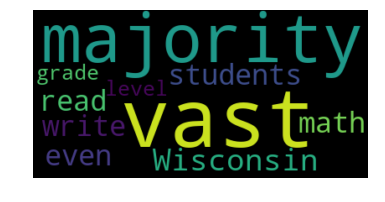

In [60]:
# generate word cloud from first statement we have (#18)
text = df.statement[18]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Uncomment to save file
#wordcloud.to_file("all_doc_cloud.png")

# WordCloud().generate_from_frequencies(text) did not work in any case

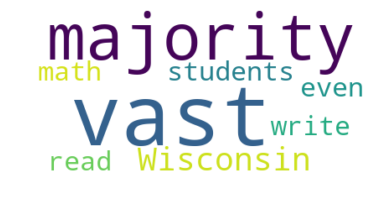

In [61]:
# changing settings
wordcloud = WordCloud(min_font_size=30, 
                      max_font_size=100, 
                      max_words=20, 
                      background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

There are 151823 words in the combination of all statements.


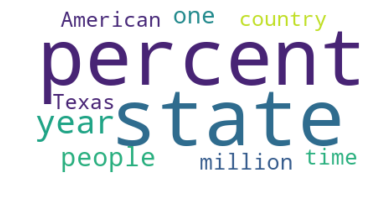

In [62]:
# Combine documents
text = " ".join( _ for _ in df.statement)
print ("There are", len(text) ,"words in the combination of all statements.")

# Generate image
wordcloud = WordCloud(min_font_size=24, 
                      max_font_size=1000, 
                      max_words=100, 
                      background_color="white").generate(text)

# Display image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
# wordcloud function for readability
def word_cloud(column):
    
    # Combine documents
    text = " ".join( _ for _ in column)
    
    # Sanity check
    print ("There are", len(text) ,"words")

    # Generate image
    plt.figure(figsize=(12, 10))
    wordcloud = WordCloud(min_font_size=5, 
                          max_font_size=60, 
                          max_words=20, 
                          background_color="white").generate(text)

    # Display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Truth Word Clouds

There are 62723 words


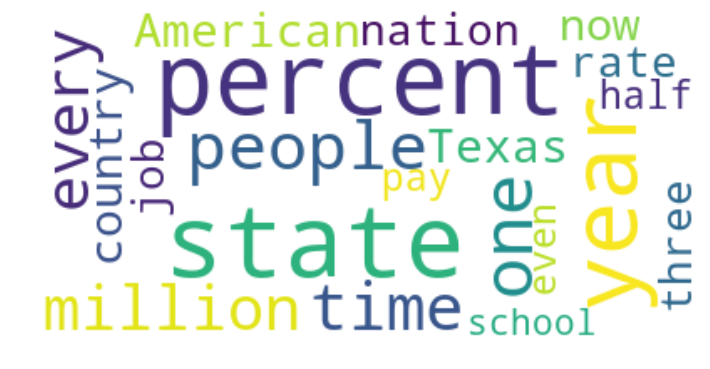

In [64]:
word_cloud(df[df.veracity == "True"].statement)

There are 35238 words


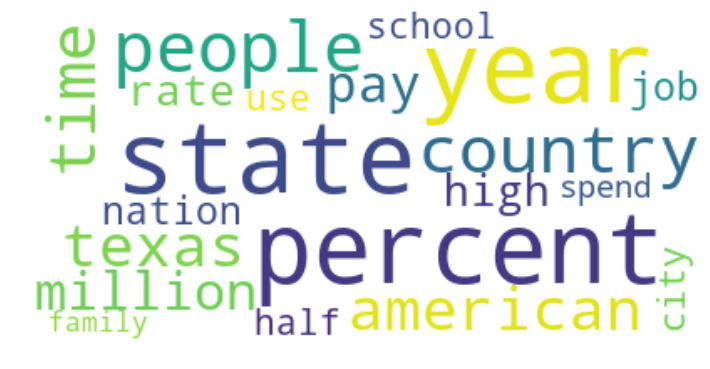

In [65]:
word_cloud(df[df.veracity == "True"].lemmas)

## Falsehood Word Clouds

There are 60153 words


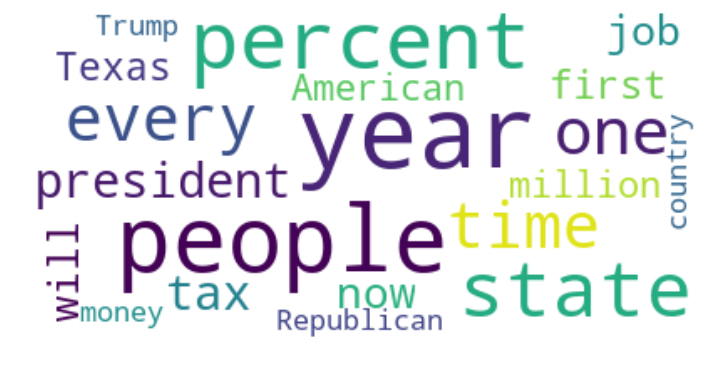

In [66]:
word_cloud(df[df.veracity == "False"].statement)

There are 34556 words


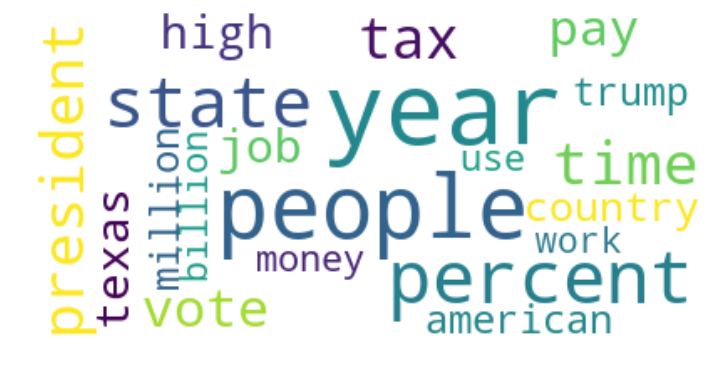

In [67]:
word_cloud(df[df.veracity == "False"].lemmas)

## Pants-on-Fire! Word Clouds

There are 28945 words


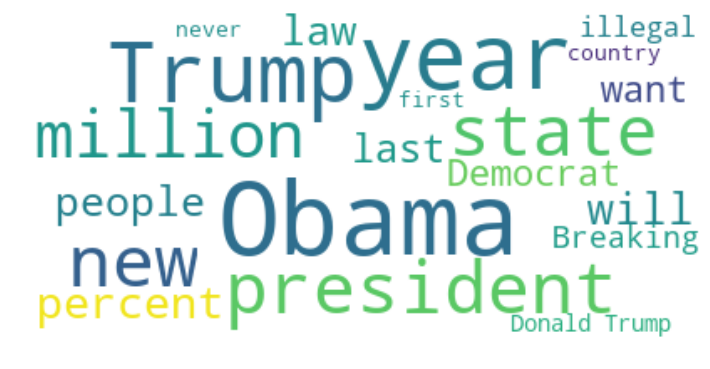

In [68]:
word_cloud(df[df.veracity == "Pants on Fire!"].statement)

There are 17721 words


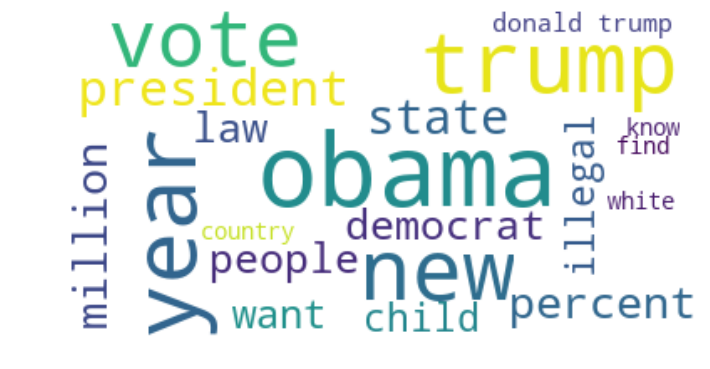

In [69]:
word_cloud(df[df.veracity == "Pants on Fire!"].lemmas)

### I find it odd that all clouds contain the words year and percent
### Let's verify with another method

In [70]:
# counter func and list of words to check
def cnt(col,r):
    # returns total # of times word occured in all statements
    return Counter(col.statement.str.contains(r))[True]

lst = [r"year", r"percent", r"state", r"American", r"half", r"Trump"]

In [71]:
# frequency func
def freq_check(df):
    # returns word and its frequency
    for r in lst:
        print(r, "freq :", cnt(df, r))

In [72]:
freq_check(df[df.veracity == "True"])

year freq : 85
percent freq : 72
state freq : 76
American freq : 32
half freq : 21
Trump freq : 7


In [73]:
freq_check(df[df.veracity == "False"])

year freq : 72
percent freq : 53
state freq : 40
American freq : 20
half freq : 9
Trump freq : 18


In [74]:
freq_check(df[df.veracity == "Pants on Fire!"])

year freq : 23
percent freq : 14
state freq : 14
American freq : 8
half freq : 4
Trump freq : 29


### results of the wordcloud were verified

In [76]:
# move veracity to the end of the dataframe for convenience
final_df = df[[cols for cols in df if cols not in ['veracity']] + ['veracity']]
final_df[200:1000:200]

,date,source,freq,statement,lemmas,general_pos_tags,specific_tags,ner_tags,statement_char_count,statement_word_count,statement_avg_word_len,lemma_char_count,lemma_word_count,lemma_avg_word_len,read_score_gun,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,tag_symbol or currency,tag_opening quotation mark,tag_closing quotation mark,tag_punctuation mark or comma,tag_left round bracket,tag_right round bracket,tag_punctuation mark or sentence closer,tag_punctuation mark or colon or ellipsis,tag_email,tag_affix,tag_conjunction or coordinating,tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,tag_punctuation mark or hyphen,tag_conjunction or subordinating or preposition,tag_adjective,tag_adjective or comparative,tag_adjective or superlative,tag_list item marker,tag_verb or modal auxiliary,tag_superfluous punctuation,tag_missing tag,tag_noun or singular or mass,tag_noun or proper singular,tag_noun or proper plural,tag_noun or plural,tag_predeterminer,tag_possessive ending,tag_pronoun or personal,tag_pronoun or possessive,tag_adverb,tag_adverb or comparative,tag_adverb or superlative,tag_adverb or particle,tag_space,tag_symbol,tag_infinitival “to”,tag_interjection,tag_verb or base form,tag_verb or past tense,tag_verb or gerund or present participle,tag_verb or past participle,tag_verb or non-3rd person singular present,tag_verb or 3rd person singular present,tag_wh-determiner,tag_wh-pronoun or personal,tag_wh-pronoun or possessive,tag_wh-adverb,tag_unknown,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,veracity
2304,2018-02-26,Patrick Morrisey,1,"""The impending work stoppage is unlawful.""",impending work stoppage unlawful,"[("", PUNCT), (The, DET), (impending, ADJ), (work, NOUN), (stoppage, NOUN), (is, AUX), (unlawful, ADJ), (., PUNCT), ("", PUNCT)]","[("", ``), (The, DT), (impending, JJ), (work, NN), (stoppage, NN), (is, VBZ), (unlawful, JJ), (., .), ("", '')]",[],42,6,6.2,32,4,7.2,15.7,2,0,0,0,1,0,2,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
3776,2016-12-23,Tdtalliance.com,1,"""Obama orders ban on Christmas cards to military.""",obama order ban christmas card military,"[("", PUNCT), (Obama, PROPN), (orders, NOUN), (ban, VERB), (on, ADP), (Christmas, PROPN), (cards, NOUN), (to, ADP), (military, NOUN), (., PUNCT), ("", PUNCT)]","[("", ``), (Obama, NNP), (orders, NNS), (ban, VBP), (on, IN), (Christmas, NNP), (cards, NNS), (to, IN), (military, NN), (., .), ("", '')]","[(Christmas, DATE)]",50,8,5.4,39,6,5.7,8.2,0,2,0,0,0,0,3,0,0,0,2,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Pants on Fire!
6693,2015-02-04,Celine Gounder,1,"""Measles is one of the most common causes of child blindness worldwide.""",measles common cause child blindness worldwide,"[("", PUNCT), (Measles, PROPN), (is, AUX), (one, NUM), (of, ADP), (the, DET), (most, ADV), (common, ADJ), (causes, NOUN), (of, ADP), (child, NOUN), (blindness, NOUN), (worldwide, ADV), (., PUNCT), ...","[("", ``), (Measles, NNP), (is, VBZ), (one, CD), (of, IN), (the, DT), (most, RBS), (common, JJ), (causes, NNS), (of, IN), (child, NN), (blindness, NN), (worldwide, RB), (., .), ("", '')]",[],72,12,5.1,46,6,6.8,4.8,1,2,2,0,1,0,3,1,0,0,1,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,2,1,0,0,0,0,0,0,2,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
8751,2013-09-30,Bill Nelson,3,"""Many state and federa